# Deep-Augmended MUSIC inference

This is a notebook made for Deep-augmented MUSIC inference and testing

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml
from scipy.io import wavfile
import IPython
import pyroomacoustics as pra

sys.path.append("src")
from src.deep.deep_music import DeepMUSIC, rmspe_loss, predict
from src.deep.synthetic_data import load_microphones, create_dataset
from src.music import music, extract_frequencies, SOUND_SPEED
from src.music_advanced import music_with_frequency
from scipy.signal import hilbert
from tqdm.notebook import tqdm
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We create a small testing set

In [2]:
test_input, test_output, test_n_sources = create_dataset('test_coherent_dataset', 100, coherent=True)

100%|██████████| 100/100 [00:00<00:00, 518.96it/s]


Import the model, you should store the model in the `models/` folder

In [3]:
mics_coords = torch.tensor(load_microphones()).to(device)

# Load the model
with open("conf/deep_music.yaml") as stream:
    try:
        conf = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


model = DeepMUSIC(mics_coords, conf)

model_path = "models/finetuned_model.pt"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

DeepMUSIC(
  (gru): GRU(48, 256)
  (post_gru): Linear(in_features=256, out_features=1152, bias=True)
  (neural_net): NeuralNet(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=1000, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=256, out_features=24, bias=True)
    )
  )
)

In [4]:
# fs, data = wavfile.read('res/arctic_a0010.wav')
# data_variance = np.var(data)
# display(IPython.display.Audio(data, rate=fs))

# room_dim = np.r_[10.,10.]
# distance = 3
# sigma2 = data_variance * 0.1
# aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# # Adding the microphones

# mics_coords = (mics_coords + room_dim / 2)
# aroom.add_microphone_array(pra.MicrophoneArray(mics_coords.T, aroom.fs))

# # Add sources of 1 second duration
# doas = np.array([30, 80]) / 180. * np.pi

# rng = np.random.RandomState(23)
# duration_samples = 10000

# for ang in doas:
#     random_phase = np.random.uniform(0, 2 * np.pi)
#     source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
#     aroom.add_source(source_location, signal=data)

# # Run the simulation
# aroom.simulate()
# aroom.plot()

Inference for one sample. You can change the `ind` to test other samples of your testing set. In red-dotted line, you find the actual doas and the lines in blue represent the predicted doas.

Sample loss : 0.04344365436012724


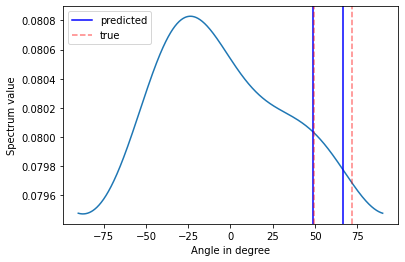

In [4]:
ind = 0

doas = test_output[ind]
samples = test_input[ind]
# samples = hilbert(aroom.mic_array.signals[:, :4000]).conj()
# samples = aroom.mic_array.signals

estimations, spectrum = predict(model, samples, 2)

X = np.linspace(-90, 90, len(spectrum))
plt.plot(X, spectrum)

print("Sample loss :", rmspe_loss(torch.tensor(estimations), doas, 2).item())


plt.xlabel("Angle in degree")
plt.ylabel("Spectrum value")

for pred, true in zip(estimations, doas):
    angle = (pred + np.pi/2) % (np.pi) - np.pi/2
    plt.axvline(angle * 180 / np.pi, color='b', label='predicted')
    angle = (true + np.pi/2) % (np.pi) - np.pi/2
    plt.axvline(angle * 180 / np.pi, color='r', alpha=0.5, linestyle='--', label="true")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

Sample loss : 0.44765680530609625
Extracted frequencies : [[-0.9424778]
 [-0.9424778]]


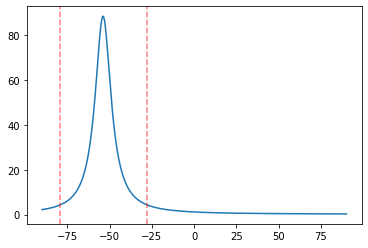

In [59]:
ind = 42

doas = test_output[ind]
samples = test_input[ind]

spectrum = music(test_input[ind], 2, mics_coords.T, SOUND_SPEED / 2, correlated=False, verbose=False)

# normalized_freq = 0.2
# fs = SOUND_SPEED / (2 * normalized_freq)
# length = 100
# spectrum = music_with_frequency(test_input[ind].conj(), 2, fs, mics_coords.T, freq_range=[normalized_freq * fs - length, normalized_freq * fs + length], correlated=False)

X = np.linspace(-90, 90, 1000)
plt.plot(X, [spectrum((x / 180) * np.pi) for x in X])


estimations = extract_frequencies(spectrum, 2, [-np.pi/2, np.pi/2], resolution=1000)

if len(estimations) == 1:
    estimations = np.array([estimations, estimations])

for pred, true in zip(estimations, doas):
    angle = (true + np.pi/2) % (np.pi) - np.pi/2
    plt.axvline(angle * 180 / np.pi, color='r', alpha=0.5, linestyle='--')

print("Sample loss :", rmspe_loss(torch.tensor(estimations), doas, 2).item())
print("Extracted frequencies :", estimations)

plt.show()

Compute the average test loss

In [60]:
def compute_test_loss(test_input, test_output, n_sources):
    losses = np.zeros(len(test_input))
    times = []

    for i, (a, doas) in tqdm(list(enumerate(zip(test_input, test_output)))):
        start = time.time_ns()
        predicted, _ = predict(model, a, n_sources)
        end = time.time_ns()
        times.append((end - start) / 1e6)

        losses[i] = rmspe_loss(torch.tensor(predicted), torch.tensor(doas), n_sources)

    return np.mean(losses), np.mean(times)

loss, average_time = compute_test_loss(test_input, test_output, 2)
print(f"Average test loss for DA-MUSIC : {loss}")
print(f"Average time in ms: {average_time}")

  0%|          | 0/100 [00:00<?, ?it/s]

Average test loss for DA-MUSIC : 0.044046723154471626
Average time in ms: 138.495177


In [63]:
def compute_standard_music_test_loss(test_input, test_output, n_sources):
    losses = []

    times = []

    for i, (a, doas) in tqdm(list(enumerate(zip(test_input, test_output)))):
        start = time.time_ns()
        # spectrum = music(a, n_sources, mics_coords.T, SOUND_SPEED / 2, correlated=False, verbose=False)

        normalized_freq = 0.2
        fs = SOUND_SPEED / (2 * normalized_freq)
        length = 10
        spectrum = music_with_frequency(a.conj(), 2, fs, mics_coords.T, freq_range=[normalized_freq * fs - length, normalized_freq * fs + length], verbose=False, correlated=False)
        
        predicted = extract_frequencies(spectrum, n_sources, [-np.pi/2, np.pi/2], resolution=1000)
        # predicted = np.random.uniform(-np.pi / 2, np.pi / 2, size=2)
        
        end = time.time_ns()
        times.append((end - start) / 1e6)

        if len(predicted) == 1:
            predicted = np.concatenate([predicted, predicted])

        losses.append(rmspe_loss(torch.tensor(predicted), torch.tensor(doas), n_sources))

    return np.mean(losses), np.mean(times)

loss, average_time = compute_standard_music_test_loss(test_input, test_output, 2)
print(f"Average test loss: {loss}")
print(f"Average time in ms: {average_time}")

  0%|          | 0/100 [00:00<?, ?it/s]

Average test loss: 0.36810443692586986
Average time in ms: 56.988404
